# Word vector process

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
#from nltk.stem.porter import PorterStemmer
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from tqdm import tqdm
import os

In [31]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
raw= pd.read_sql_query(""" SELECT * FROM Reviews """, con) 

<AxesSubplot:>

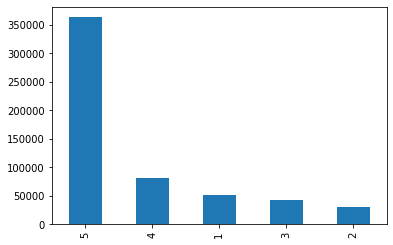

In [34]:
(raw['Score'].value_counts()).plot(kind='bar')

In [30]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 2000""", con) 
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (2000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


<AxesSubplot:>

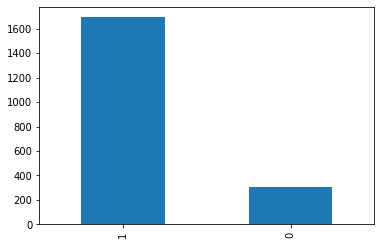

In [35]:
(filtered_data['Score'].value_counts()).plot(kind='bar')

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(1998, 10)

In [5]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.9

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [7]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(1998, 10)


1    1691
0     307
Name: Score, dtype: int64

In [8]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [9]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [10]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'html.parser').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 1998/1998 [00:00<00:00, 3352.39it/s]


In [11]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aahhhs', 'abates', 'abby', 'abdominal', 'abiding', 'ability', 'able', 'aboulutely', 'absence', 'absent']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (1998, 7992)
the number of unique words  7992


In [12]:
final['Score'].value_counts(0)

1    1691
0     307
Name: Score, dtype: int64

# Data imbalance processing

In [13]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from collections import Counter
from sklearn.metrics import roc_auc_score,recall_score,precision_score,roc_curve,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

<AxesSubplot:>

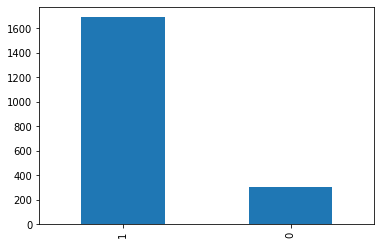

In [14]:
count_class=pd.value_counts(final['Score'],sort=True)
count_class.plot(kind='bar')

In [43]:
count_class

1    1691
0     307
Name: Score, dtype: int64

In [15]:
#transform words bow
X=preprocessed_reviews
x_bow=count_vect.fit_transform(X)
y=np.array(final['Score'])

In [41]:
X

['received shipment could hardly wait try product love slickers call instead stickers removed easily daughter designed signs printed reverse use car windows printed beautifully print shop program going lot fun product windows everywhere surfaces like tv screens computer monitors',
 'really good idea final product outstanding use decals car window everybody asks bought decals made two thumbs',
 'nine cats crazy kibbles last thing want cat food cats hate buying',
 'product allows make really big splashes providing spiced nuts gatherings fact gold spreads easily allows use little show people amazed edible gold',
 'purchased item cake called gold dust never thought would find im glad sprinkled looked like shining star container small go long way worth buying',
 'used product multiple times fact purchased four tubs gold silver luster dust five years ago running use stuff gild sorts things renaissance themed banquets including gilding entire roast duck using vodka painting filigree designs o

In [40]:
x_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [16]:
x_bow.shape

(1998, 7992)

In [17]:
#Splitting preprocessed reviews into train,cross validation and test
x_train, x_test, y_train, y_test = train_test_split(x_bow, y, test_size=0.2, random_state=0)

In [42]:
len(y_train)

1598

In [54]:
dff=pd.DataFrame(y_train)
dff[0].value_counts()

1    1360
0     238
Name: 0, dtype: int64

(array([ 238.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

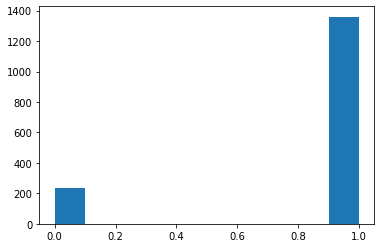

In [51]:
plt.hist(y_train)

In [18]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek

ros = RandomOverSampler(random_state=0) # 随机过采样
sos = SMOTE(random_state=0)      # SMOTE过采样
kos = SMOTETomek(random_state=0)  # 综合采样

In [19]:
#Random oversampling
ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(x_train, y_train)
ros_c = Counter(y_ros)
print(ros_c)

Counter({0: 1360, 1: 1360})


In [20]:
#SMOTE oversampling
x_sos, y_sos = sos.fit_resample(x_train, y_train)
sos_c = Counter(y_sos)
print(sos_c)

Counter({0: 1360, 1: 1360})


In [21]:
#SMOTETomek sampling
x_kos, y_kos = kos.fit_resample(x_train, y_train)
kos_c = Counter(y_kos)
print(kos_c)

Counter({0: 1360, 1: 1360})


In [22]:
y_ros.sum(), y_sos.sum(), y_kos.sum()

(1360, 1360, 1360)

In [23]:
clf = RandomForestClassifier(n_estimators = 2, criterion="gini",random_state=123)

In [24]:
#train
data = [[x_train, y_train],
        [x_ros, y_ros],
        [x_sos, y_sos],
        [x_kos, y_kos]]
lab=[]
auc=[]
fpr=[]
tpr=[]
precision=[]
recall=[]
pred=[]
for bow,labels in data:
    lab.append(len(labels))
    scalar = StandardScaler(with_mean=False)
    x_train_s= scalar.fit_transform(bow)
    x_test_s= scalar.transform(x_test)
    x_train_t=x_train_s.todense()
    x_test_t=x_test_s.todense()
    clf.fit(x_train_t, labels)
    pred_p=clf.predict_proba(x_test_t)[:,1]
    predi=clf.predict(x_test_t)
    pred.append(predi)
    auc.append(roc_auc_score(y_test,pred_p))    
    recall.append(recall_score(y_test,predi))
    precision.append(precision_score(y_test,predi))    
    fpri, tpri, thresholdsi = roc_curve(y_test,pred_p)
    fpr.append(fpri)
    tpr.append(tpri)


In [25]:
lab

[1598, 2720, 2720, 2720]

In [56]:
tpr

[array([0.        , 0.81873112, 0.99093656, 1.        ]),
 array([0.        , 0.72809668, 0.95770393, 1.        ]),
 array([0.        , 0.51359517, 0.84592145, 1.        ]),
 array([0.        , 0.51359517, 0.84592145, 1.        ])]

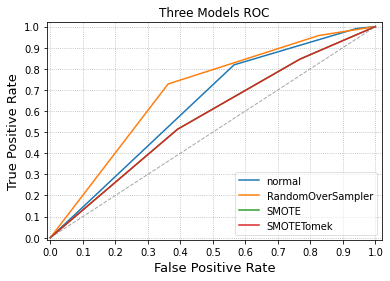

In [59]:
method=['normal','RandomOverSampler','SMOTE','SMOTETomek']
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=method[i])
plt.title('Three Models ROC')
plt.legend(loc='lower right', fancybox=True, framealpha=0.6, fontsize=10)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')

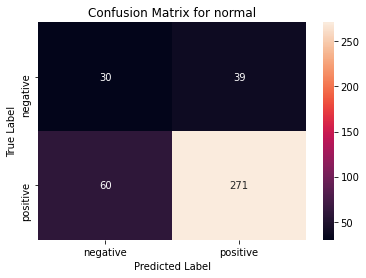

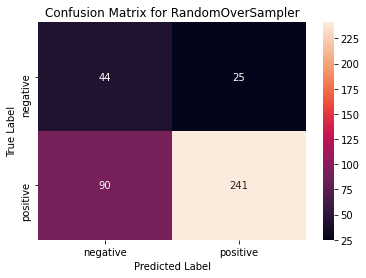

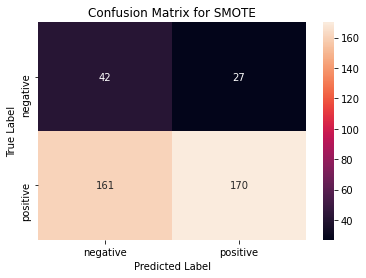

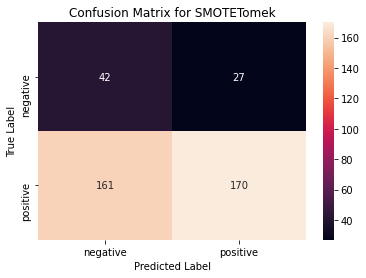

In [27]:
for i in range(4):
    conf_mat = confusion_matrix(y_test,pred[i])
    class_label = ['negative', 'positive']
    df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
    fig = plt.figure()
    sns.heatmap(df, annot = True,fmt="d")  
    plt.title("Confusion Matrix for "+method[i])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    

In [28]:
for i in range(4):
    print('='*50)
    print(method[i])
    print('auc'+str(np.round(auc[i],3)))
    print('precision'+str(np.round(precision[i],3)))
    print('recall'+str(np.round(recall[i],3)))

normal
auc0.63
precision0.874
recall0.819
RandomOverSampler
auc0.693
precision0.906
recall0.728
SMOTE
auc0.571
precision0.863
recall0.514
SMOTETomek
auc0.571
precision0.863
recall0.514
